In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization, RandomAffine, RandomNoise, ToCanonical, CropOrPad)

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pickle

import copy


from Networks_Training import UNet_1_layer, UNet_2_layer

In [2]:
# Load the dictionary for AE training 
with open('design_ae_training.pkl', 'rb') as f:
    design_ae_training = pickle.load(f)

In [3]:
# With design_ae_training create a dictionary that will be used for dataset->dataloader creation

dict_ae_training=copy.deepcopy(design_ae_training)
         
for group in design_ae_training.keys():
    for dataset in design_ae_training[group].keys():
        for label in design_ae_training[group][dataset].keys():
                        
            dict_ae_training[group][dataset][label]=[tio.Subject(chiasm=tio.Image('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz', type = tio.INTENSITY)) 
                                                  for subject in design_ae_training[group][dataset][label]]

In [4]:
# Histogram standardization (to mitigate cross-site differences)
# Standardization is performed on all datasets

# Save paths of all images
chiasm_paths=[]

for group in design_ae_training.keys():
    for dataset in design_ae_training[group].keys():
        for label in design_ae_training[group][dataset].keys():
            for subject in design_ae_training[group][dataset][label]:
                chiasm_paths.append('../../1_Data/1_Input/'+dataset+'/'+subject+'/chiasm.nii.gz')

chiasm_landmarks_paths = Path('chiasm_landmarks.npy') 

chiasm_landmarks = HistogramStandardization.train(chiasm_paths)

torch.save(chiasm_landmarks, chiasm_landmarks_paths)

landmarks={'chiasm': chiasm_landmarks}

standardize = HistogramStandardization(landmarks)

100%|█████████████████████████████████████| 1742/1742 [00:01<00:00, 1010.62it/s]


In [5]:
# Transforms

# Rescale
rescale = RescaleIntensity((0,1))

# Crop 
crop = CropOrPad((24,24,8))

# Composing transforms 
transform = Compose([standardize, rescale, crop]) 

In [6]:
# Create Torchio dataset

dataset_ae_training = {}

for group in dict_ae_training.keys():
    
    dataset_ae_training[group]={}
    
    for dataset in dict_ae_training[group].keys():
        
        dataset_ae_training[group][dataset]={}
            
        for label in dict_ae_training[group][dataset].keys():
            
            dataset_ae_training[group][dataset][label]=tio.SubjectsDataset(dict_ae_training[group][dataset][label], transform=transform)
            

In [7]:
dataset_ae_training

{'train': {'ABIDE': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8e50>},
  'Athletes': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8c70>},
  'HCP': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8c40>},
  'COBRE': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8820>},
  'Leipzig': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8400>},
  'MCIC': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8640>}},
 'dev_train': {'ABIDE': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8b80>},
  'Athletes': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8eb0>},
  'HCP': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8be0>},
  'COBRE': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8490>},
  'Leipzig': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba04f8130>},
  'MCIC': {'control': <torchio.data.dataset.SubjectsDataset at 0x7f4ba

In [8]:
dataloader_chiasm={}

for group in ['dev_test','test']:
    dataloader_chiasm[group]={}
    for dataset in dataset_ae_training[group].keys():
        dataloader_chiasm[group][dataset]={}
        for label in dataset_ae_training[group][dataset].keys():
            dataloader_chiasm[group][dataset][label]=DataLoader(dataset=dataset_ae_training[group][dataset][label], batch_size=10, shuffle=True, num_workers=8)


## Evaluation of results

### Overview of results

In [9]:
# Evaluate all the approaches, calculate average MSE loss per image and save it to dictionary
loss_function = nn.MSELoss(reduction='sum')

In [10]:
main_path = '../../1_Data/2_Trained_AE/'

architectures = [os.path.basename(x) for x in glob.glob(main_path+'1_layer*')]
architectures += [os.path.basename(x) for x in glob.glob(main_path+'/2_layer*')]

results={}

for architecture in architectures:
    results['Encoder_'+os.path.basename(architecture)]={}
    
    for method in results.keys():
        for group in dataloader_chiasm.keys():
            results[method][group]={}
            for dataset in dataloader_chiasm[group].keys():
                results[method][group][dataset]={}
                for label in dataloader_chiasm[group][dataset].keys():
                    results[method][group][dataset][label]={}

# For autoencoder
for architecture in architectures:
    
    # Extract the parameters
    params = os.path.basename(architecture)
    params_split = params.split('_')
    
    # Instantiate the proper network
    if int(params_split[0]) == 1:
        network = UNet_1_layer(1,1,int(params_split[2]),int(params_split[3]))
    elif int(params_split[0]) == 2:
        network = UNet_2_layer(1,1,int(params_split[2]),int(params_split[3]))
    
    # Load the weights
    network.load_state_dict(torch.load(main_path+architecture+'/optimal_weights'))
    
    # Assess the results
    network.eval()
    
    for group in ['dev_test','test']:
        for dataset in dataloader_chiasm[group].keys():
            for label in dataloader_chiasm[group][dataset]:
                
                total_loss = 0.0
                
                for batch in dataloader_chiasm[group][dataset][label]:
                    
                    with torch.no_grad():
                        prediction = network(batch['chiasm']['data'])
                        
                    total_loss += loss_function(batch['chiasm']['data'],prediction)
                    
                loss_per_image = total_loss/len(dataset_ae_training[group][dataset][label])
                
                results['Encoder_'+params][group][dataset][label] = loss_per_image.detach().numpy()

In [30]:
main_path = '../../1_Data/2_Trained_AE/'

architectures = [os.path.basename(x) for x in glob.glob(main_path+'1_layer*')]
architectures += [os.path.basename(x) for x in glob.glob(main_path+'/2_layer*')]

results={}

for architecture in architectures:
    results['Encoder_'+os.path.basename(architecture)]={}
    
    for method in results.keys():
        for group in dataloader_chiasm.keys():
            results[method][group]={}
            for dataset in dataloader_chiasm[group].keys():
                if dataset == 'UoN':
                    dataset = 'Ather et al.'
                results[method][group][dataset]={}
                if dataset == 'Ather et al.':
                    dataset = 'UoN'
                for label in dataloader_chiasm[group][dataset].keys():
                    if dataset == 'UoN':
                        dataset = 'Ather et al.'
                    results[method][group][dataset][label]={}

# For autoencoder
for architecture in architectures:
    
    # Extract the parameters
    params = os.path.basename(architecture)
    params_split = params.split('_')
    
    # Instantiate the proper network
    if int(params_split[0]) == 1:
        network = UNet_1_layer(1,1,int(params_split[2]),int(params_split[3]))
    elif int(params_split[0]) == 2:
        network = UNet_2_layer(1,1,int(params_split[2]),int(params_split[3]))
    
    # Load the weights
    network.load_state_dict(torch.load(main_path+architecture+'/optimal_weights'))
    
    # Assess the results
    network.eval()
    
    for group in ['dev_test','test']:
        for dataset in dataloader_chiasm[group].keys():
            
            
            for label in dataloader_chiasm[group][dataset]:
                
                total_loss = 0.0
                
                for batch in dataloader_chiasm[group][dataset][label]:
                    
                    with torch.no_grad():
                        prediction = network(batch['chiasm']['data'])
                        
                    total_loss += loss_function(batch['chiasm']['data'],prediction)
                    
                loss_per_image = total_loss/len(dataset_ae_training[group][dataset][label])
                
                if dataset == 'UoN':
                    dataset = 'Ather et al.'
                
                results['Encoder_'+params][group][dataset][label] = loss_per_image.detach().numpy()
                
                if dataset == 'Ather et al.':
                    dataset = 'UoN'

In [31]:
results

{'Encoder_1_layer_2_2': {'dev_test': {'ABIDE': {'control': array(17.0838, dtype=float32)},
   'Athletes': {'control': array(9.671288, dtype=float32)},
   'HCP': {'control': array(11.868701, dtype=float32)},
   'COBRE': {'control': array(14.090709, dtype=float32)},
   'Leipzig': {'control': array(28.239975, dtype=float32)},
   'MCIC': {'control': array(21.048677, dtype=float32)},
   'CHIASM': {'control': array(47.061836, dtype=float32),
    'albinism': array(33.21097, dtype=float32)},
   'Ather et al.': {'control': array(15.560924, dtype=float32),
    'albinism': array(23.833887, dtype=float32)}},
  'test': {'CHIASM': {'control': array(48.403805, dtype=float32),
    'albinism': array(39.839973, dtype=float32)},
   'Ather et al.': {'control': array(25.78463, dtype=float32),
    'albinism': array(25.971472, dtype=float32)}}},
 'Encoder_1_layer_4_1': {'dev_test': {'ABIDE': {'control': array(20.449022, dtype=float32)},
   'Athletes': {'control': array(11.575418, dtype=float32)},
   'HCP': {

In [14]:
# To avoid test data spoiling
#for method in results.keys():
#    results[method]['test']['CHIASM']={}
#    results[method]['test']['UoN']={}

In [15]:
# Save the results
#with open('Results_AE_training.pkl', 'wb') as f:
#    pickle.dump(results,f)

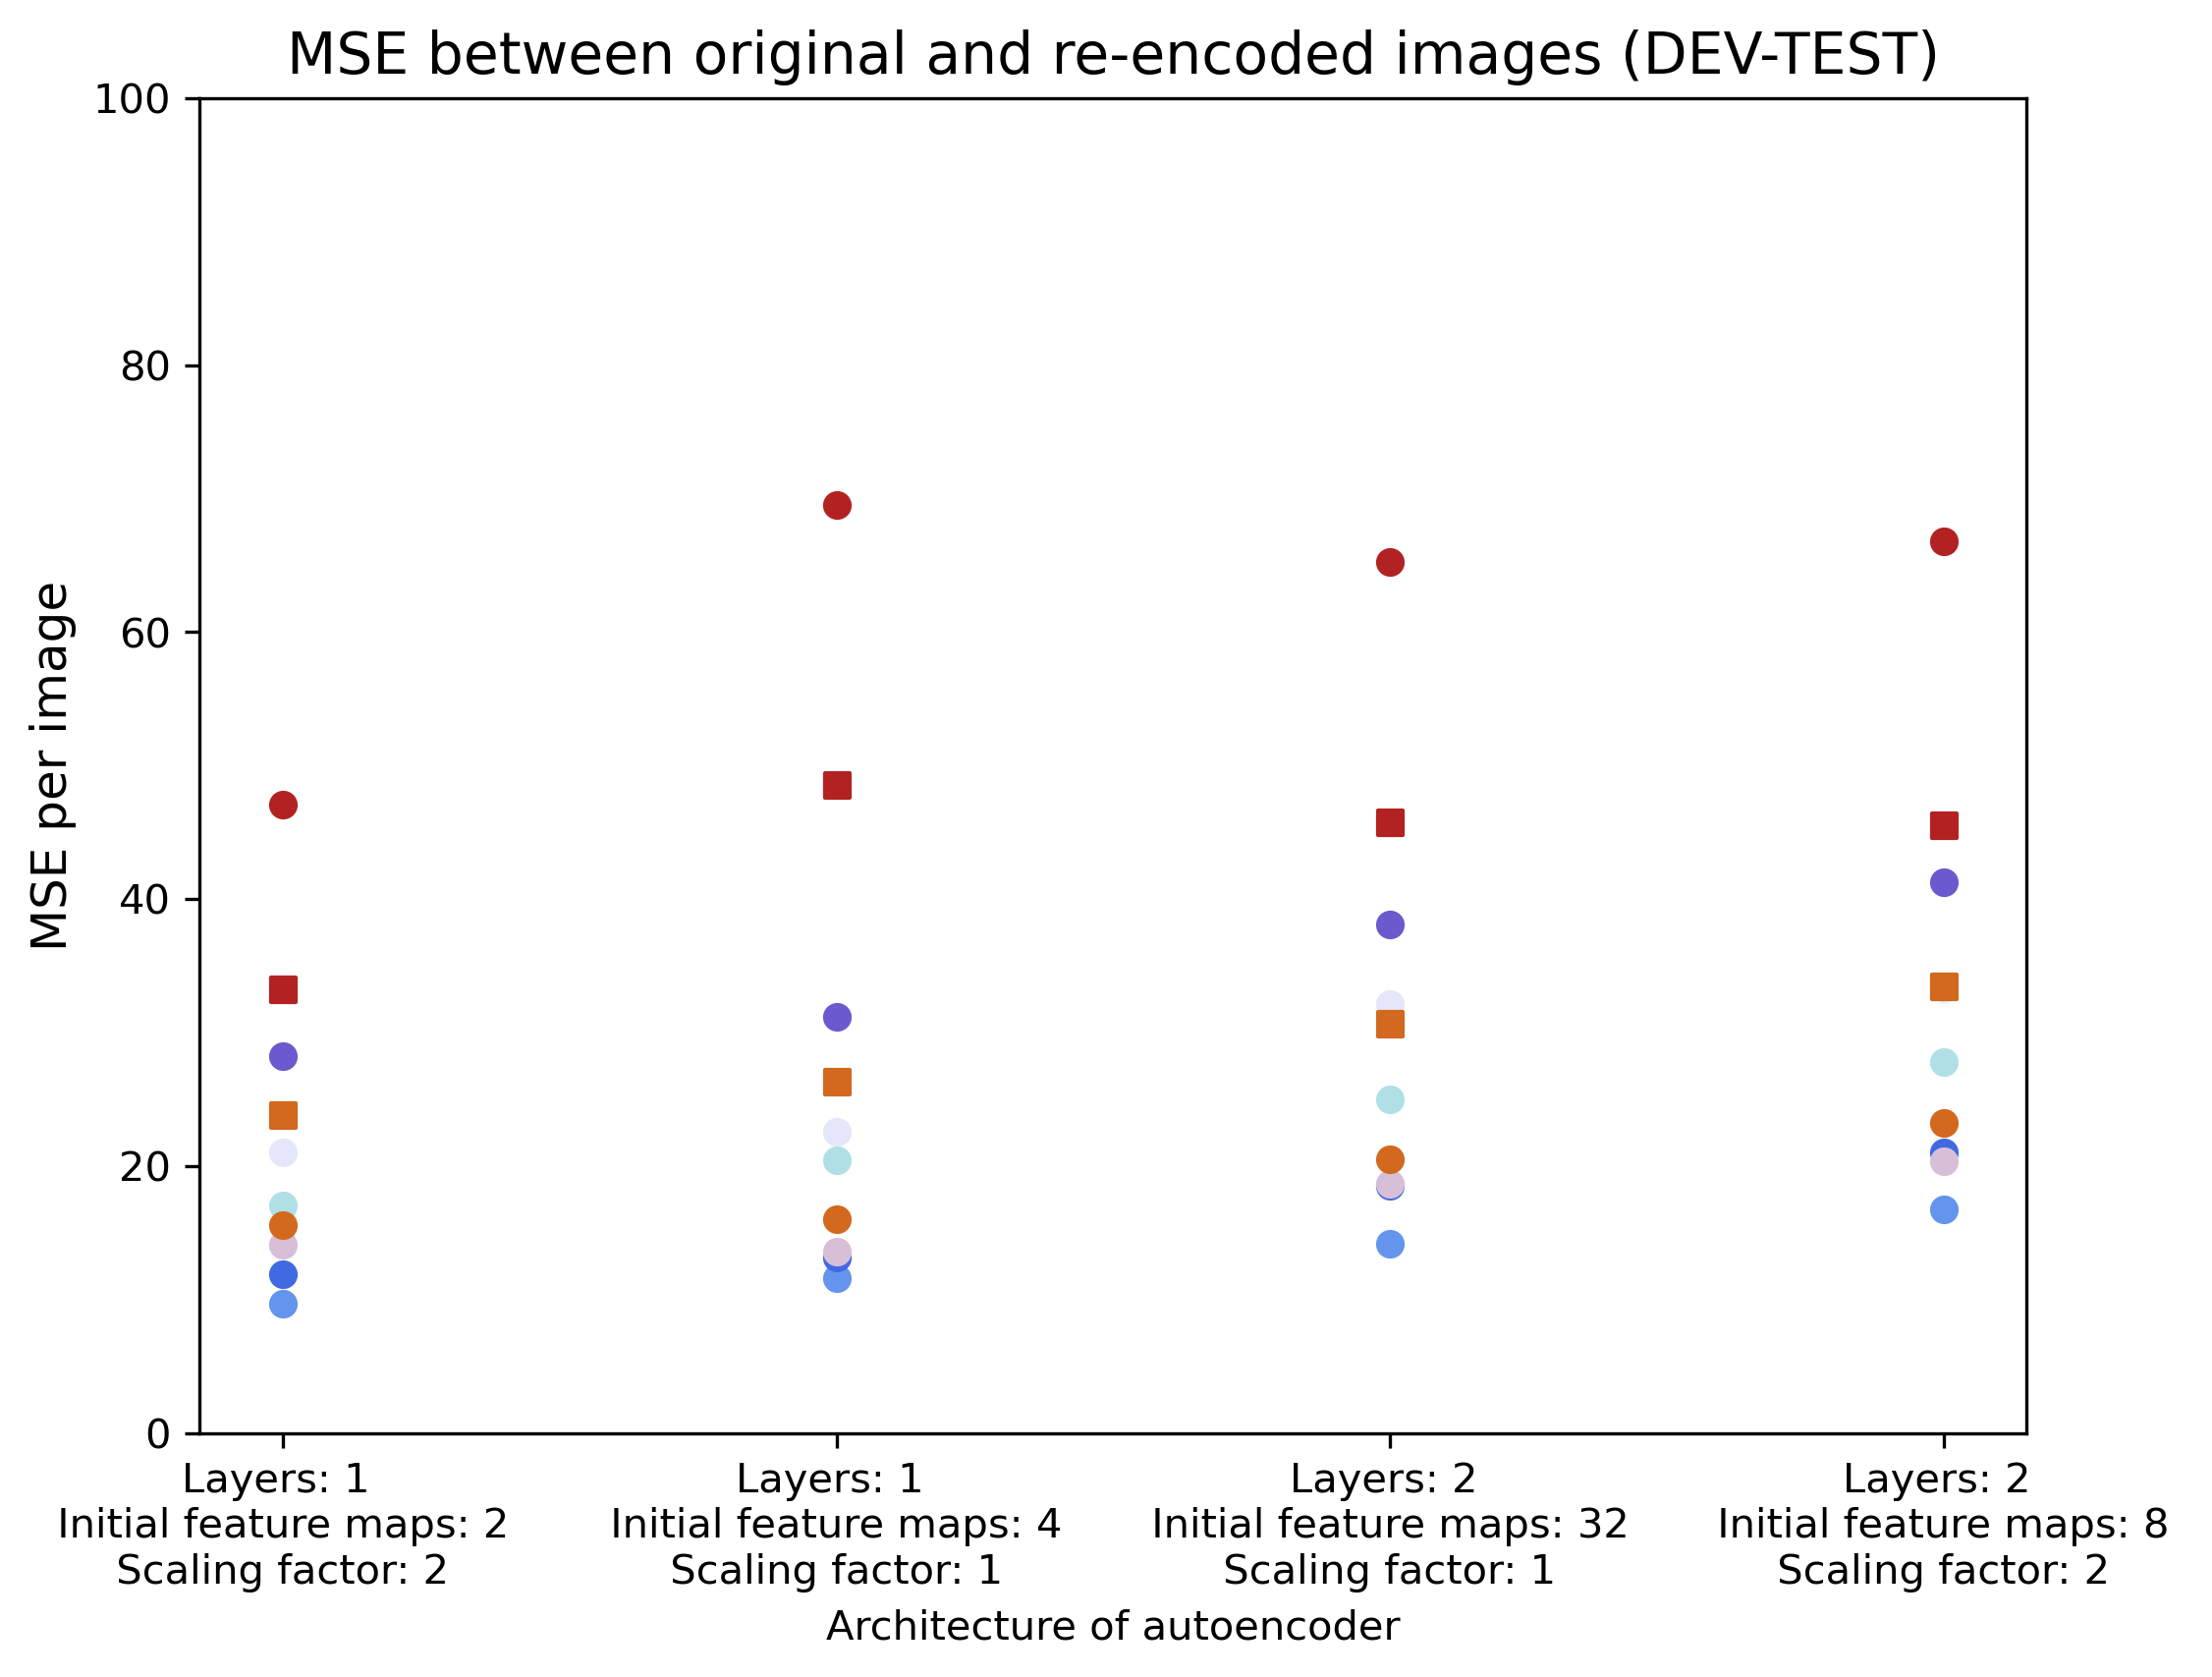

In [47]:
# Plot the results

plt.figure(figsize=(8, 6), dpi=300)

colormap={'ABIDE':'lightsteelblue',
         'Athletes':'cornflowerblue',
         'HCP':'royalblue',
         'MCIC':'lavender',
         'Leipzig':'slateblue',
          'COBRE':'thistle',
         'ABIDE':'powderblue',
         'CHIASM':'firebrick',
         'Ather et al.':'chocolate',}

first=0
second=0

for method in results.keys():
    for dataset in results[method]['dev_test']:
        if(first==0):
            plt.scatter(method,results[method]['dev_test'][dataset]['control'],c=colormap[dataset], label=' control '+dataset)
        else:
            plt.scatter(method,results[method]['dev_test'][dataset]['control'],c=colormap[dataset])
    first=1
    
    for dataset in ['Ather et al.','CHIASM']:
        if(second==0):
            plt.scatter(method,results[method]['dev_test'][dataset]['albinism'],c=colormap[dataset], marker ='s', label=' albinism '+dataset)
        else:
            plt.scatter(method,results[method]['dev_test'][dataset]['albinism'],c=colormap[dataset], marker='s')
    second=1
        
plt.ylim([0,100])
        
plt.title('MSE between original and re-encoded images (DEV-TEST)', fontsize=14)
#plt.legend(scatterpoints=1, loc='best',  bbox_to_anchor=(1.0, 1.015));
plt.xlabel('Architecture of autoencoder');
plt.xticks(rotation=-60)
plt.ylabel('MSE per image', fontsize=12);

plt.xticks([0,1,2,3],['Layers: 1 \n Initial feature maps: 2 \n Scaling factor: 2 ',
                      'Layers: 1 \n Initial feature maps: 4 \n Scaling factor: 1 ',
                       'Layers: 2 \n Initial feature maps: 32 \n Scaling factor: 1 ',
                       'Layers: 2 \n Initial feature maps: 8 \n Scaling factor: 2 '], 
           rotation=0);

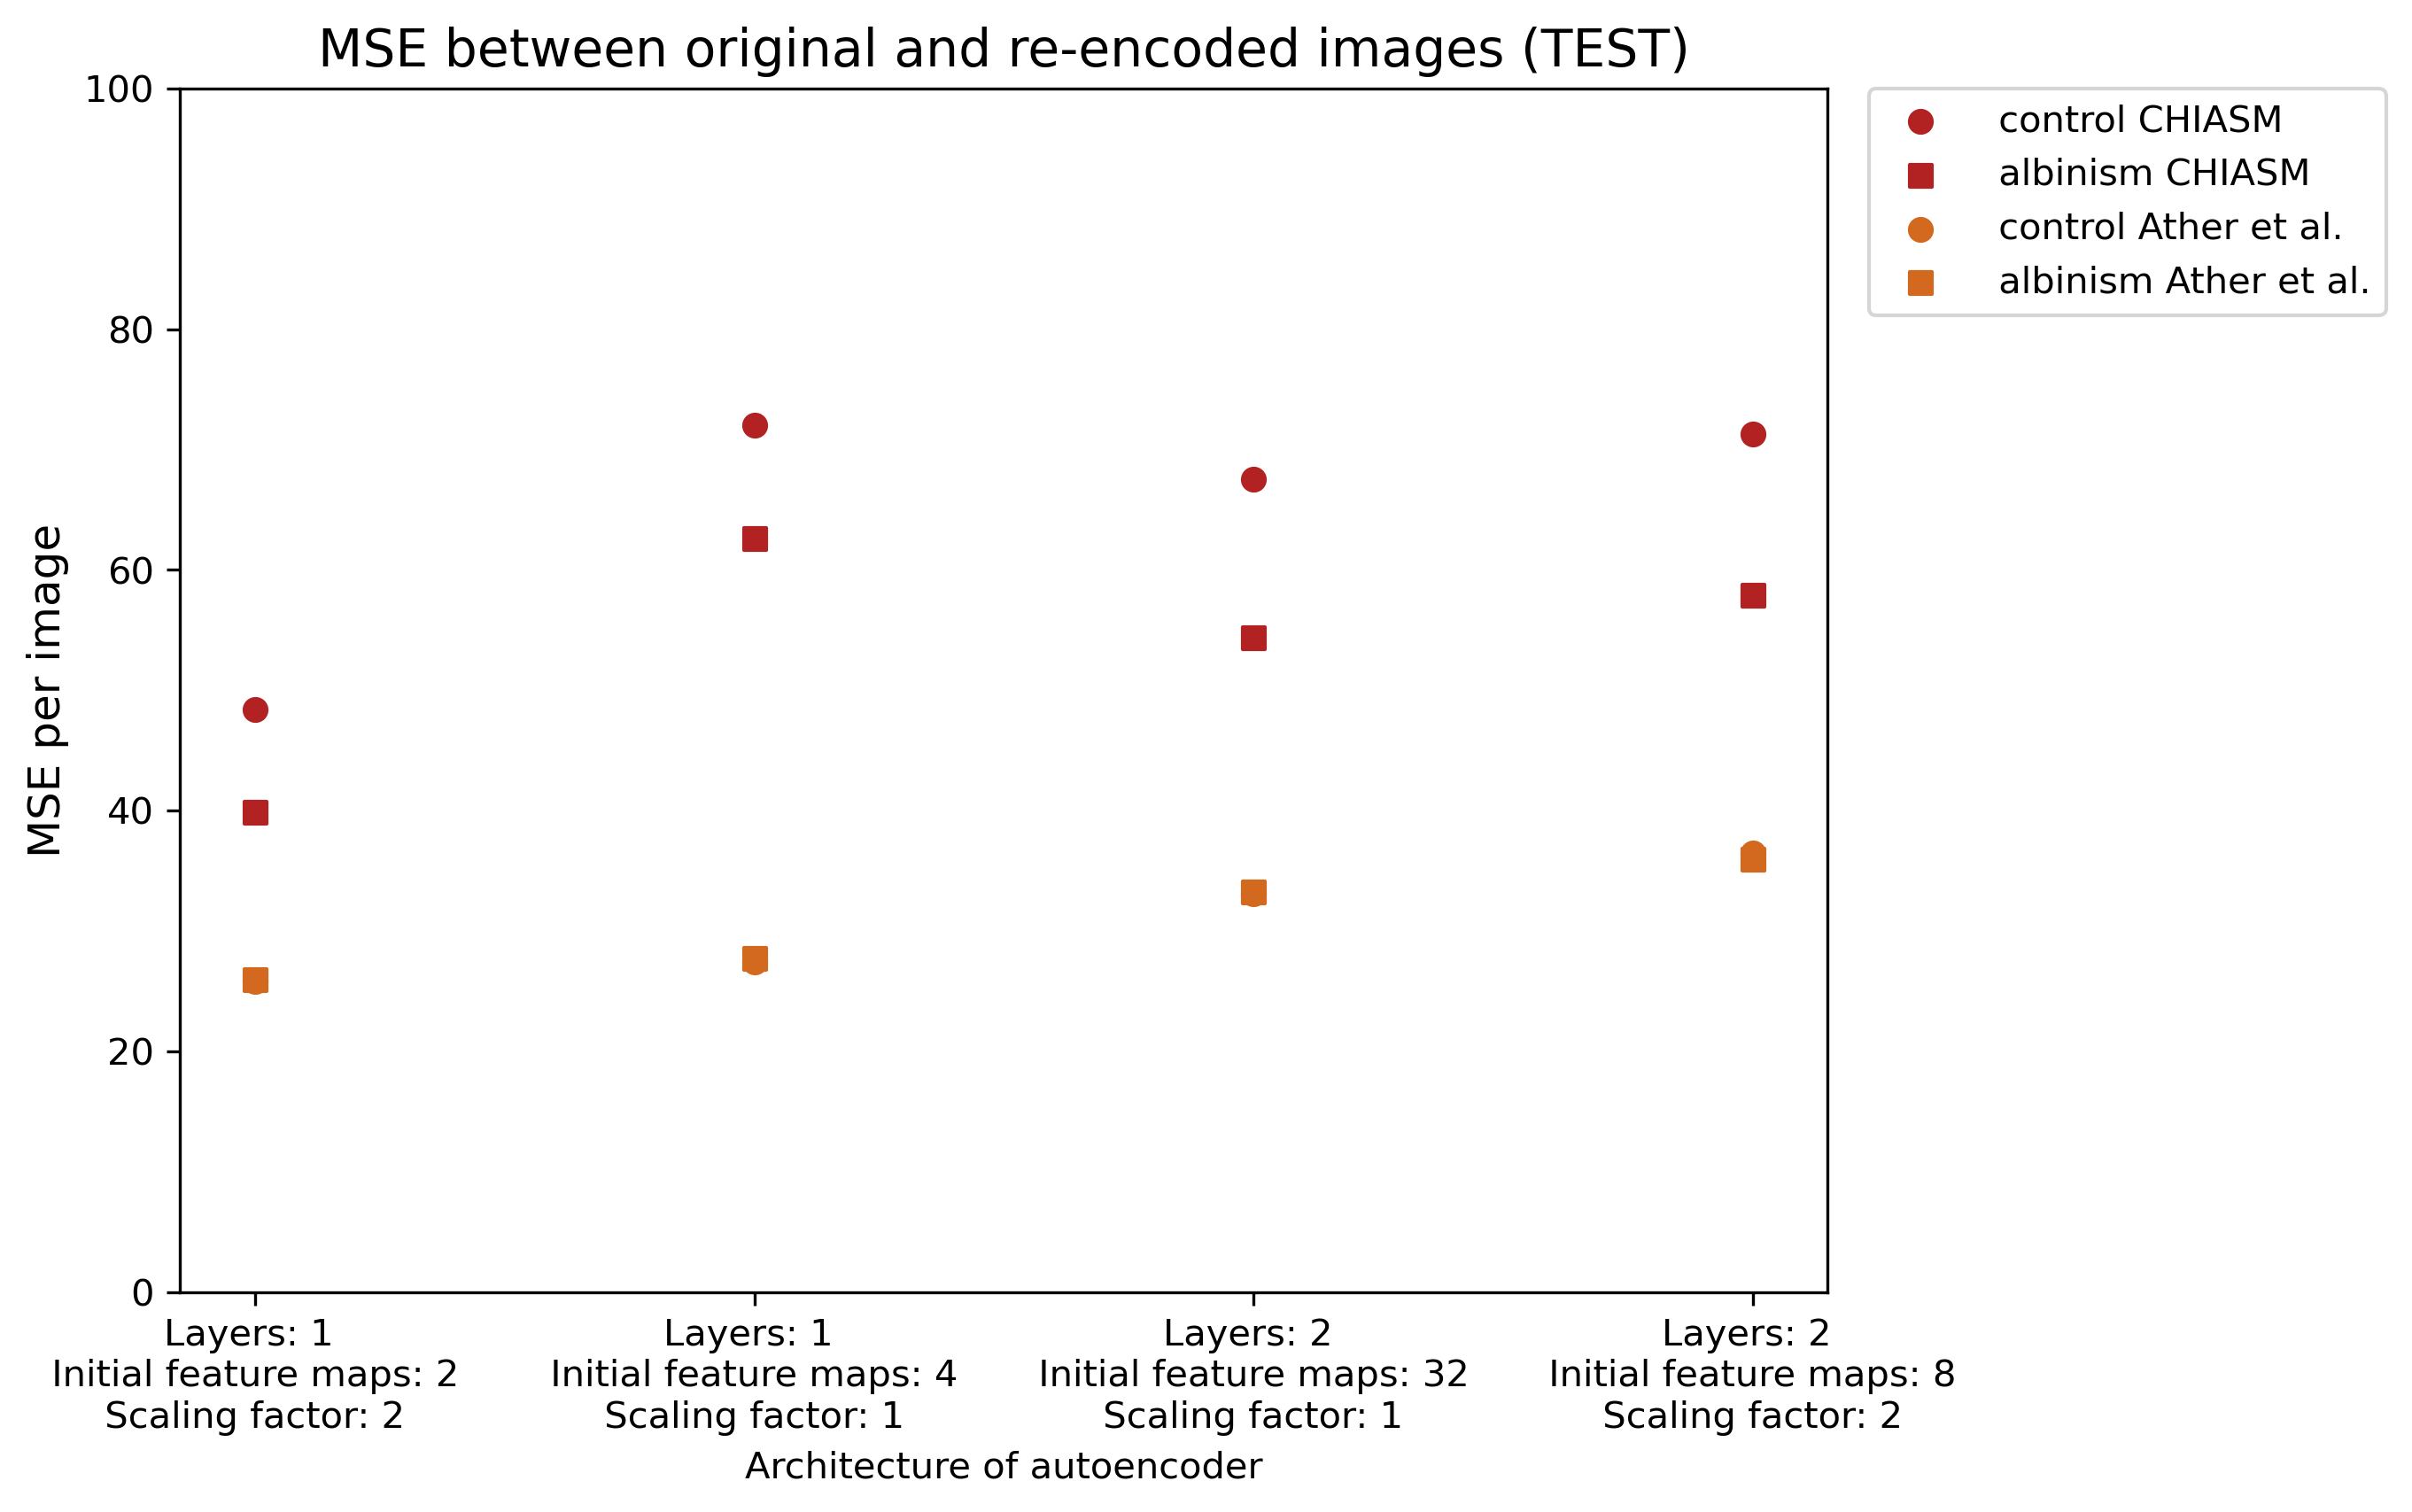

In [46]:
# Plot the results

plt.figure(figsize=(8, 6), dpi=300)

colormap={'ABIDE':'lightsteelblue',
         'Athletes':'cornflowerblue',
         'HCP':'royalblue',
         'MCIC':'lavender',
         'Leipzig':'slateblue',
          'COBRE':'thistle',
         'ABIDE':'powderblue',
         'CHIASM':'firebrick',
         'Ather et al.':'chocolate',}

first=0
second=0

for method in results.keys():
    for dataset in results[method]['test']:
        if(first==0):
            plt.scatter(method,results[method]['test'][dataset]['control'],c=colormap[dataset], label=' control '+dataset)
        else:
            plt.scatter(method,results[method]['test'][dataset]['control'],c=colormap[dataset])
    
        if(second==0):
            plt.scatter(method,results[method]['test'][dataset]['albinism'],c=colormap[dataset], marker ='s', label=' albinism '+dataset)
        else:
            plt.scatter(method,results[method]['test'][dataset]['albinism'],c=colormap[dataset], marker='s')
    
    first=1
    second=1
        
plt.ylim([0,100])
        
plt.title('MSE between original and re-encoded images (TEST)', fontsize=14)
plt.legend(scatterpoints=1, loc='best',  bbox_to_anchor=(1.35, 1.015));
plt.xlabel('Architecture of autoencoder');
plt.xticks(rotation=-60)
plt.ylabel('MSE per image', fontsize=12);

plt.xticks([0,1,2,3],['Layers: 1 \n Initial feature maps: 2 \n Scaling factor: 2 ',
                      'Layers: 1 \n Initial feature maps: 4 \n Scaling factor: 1 ',
                       'Layers: 2 \n Initial feature maps: 32 \n Scaling factor: 1 ',
                       'Layers: 2 \n Initial feature maps: 8 \n Scaling factor: 2 '], 
           rotation=0);

In [16]:
# Prime candidate is encoder_1_layer_2_2
# and encoder_2_layer_2_4

### Inspect the training progress

In [17]:
def load_training(path):
    
    with open(path+'/train_loss.pkl', 'rb') as f:
        train_loss = pickle.load(f)
    
    with open(path+'/dev_train_loss.pkl', 'rb') as f:
        dev_train_loss = pickle.load(f)
    
    return train_loss, dev_train_loss 

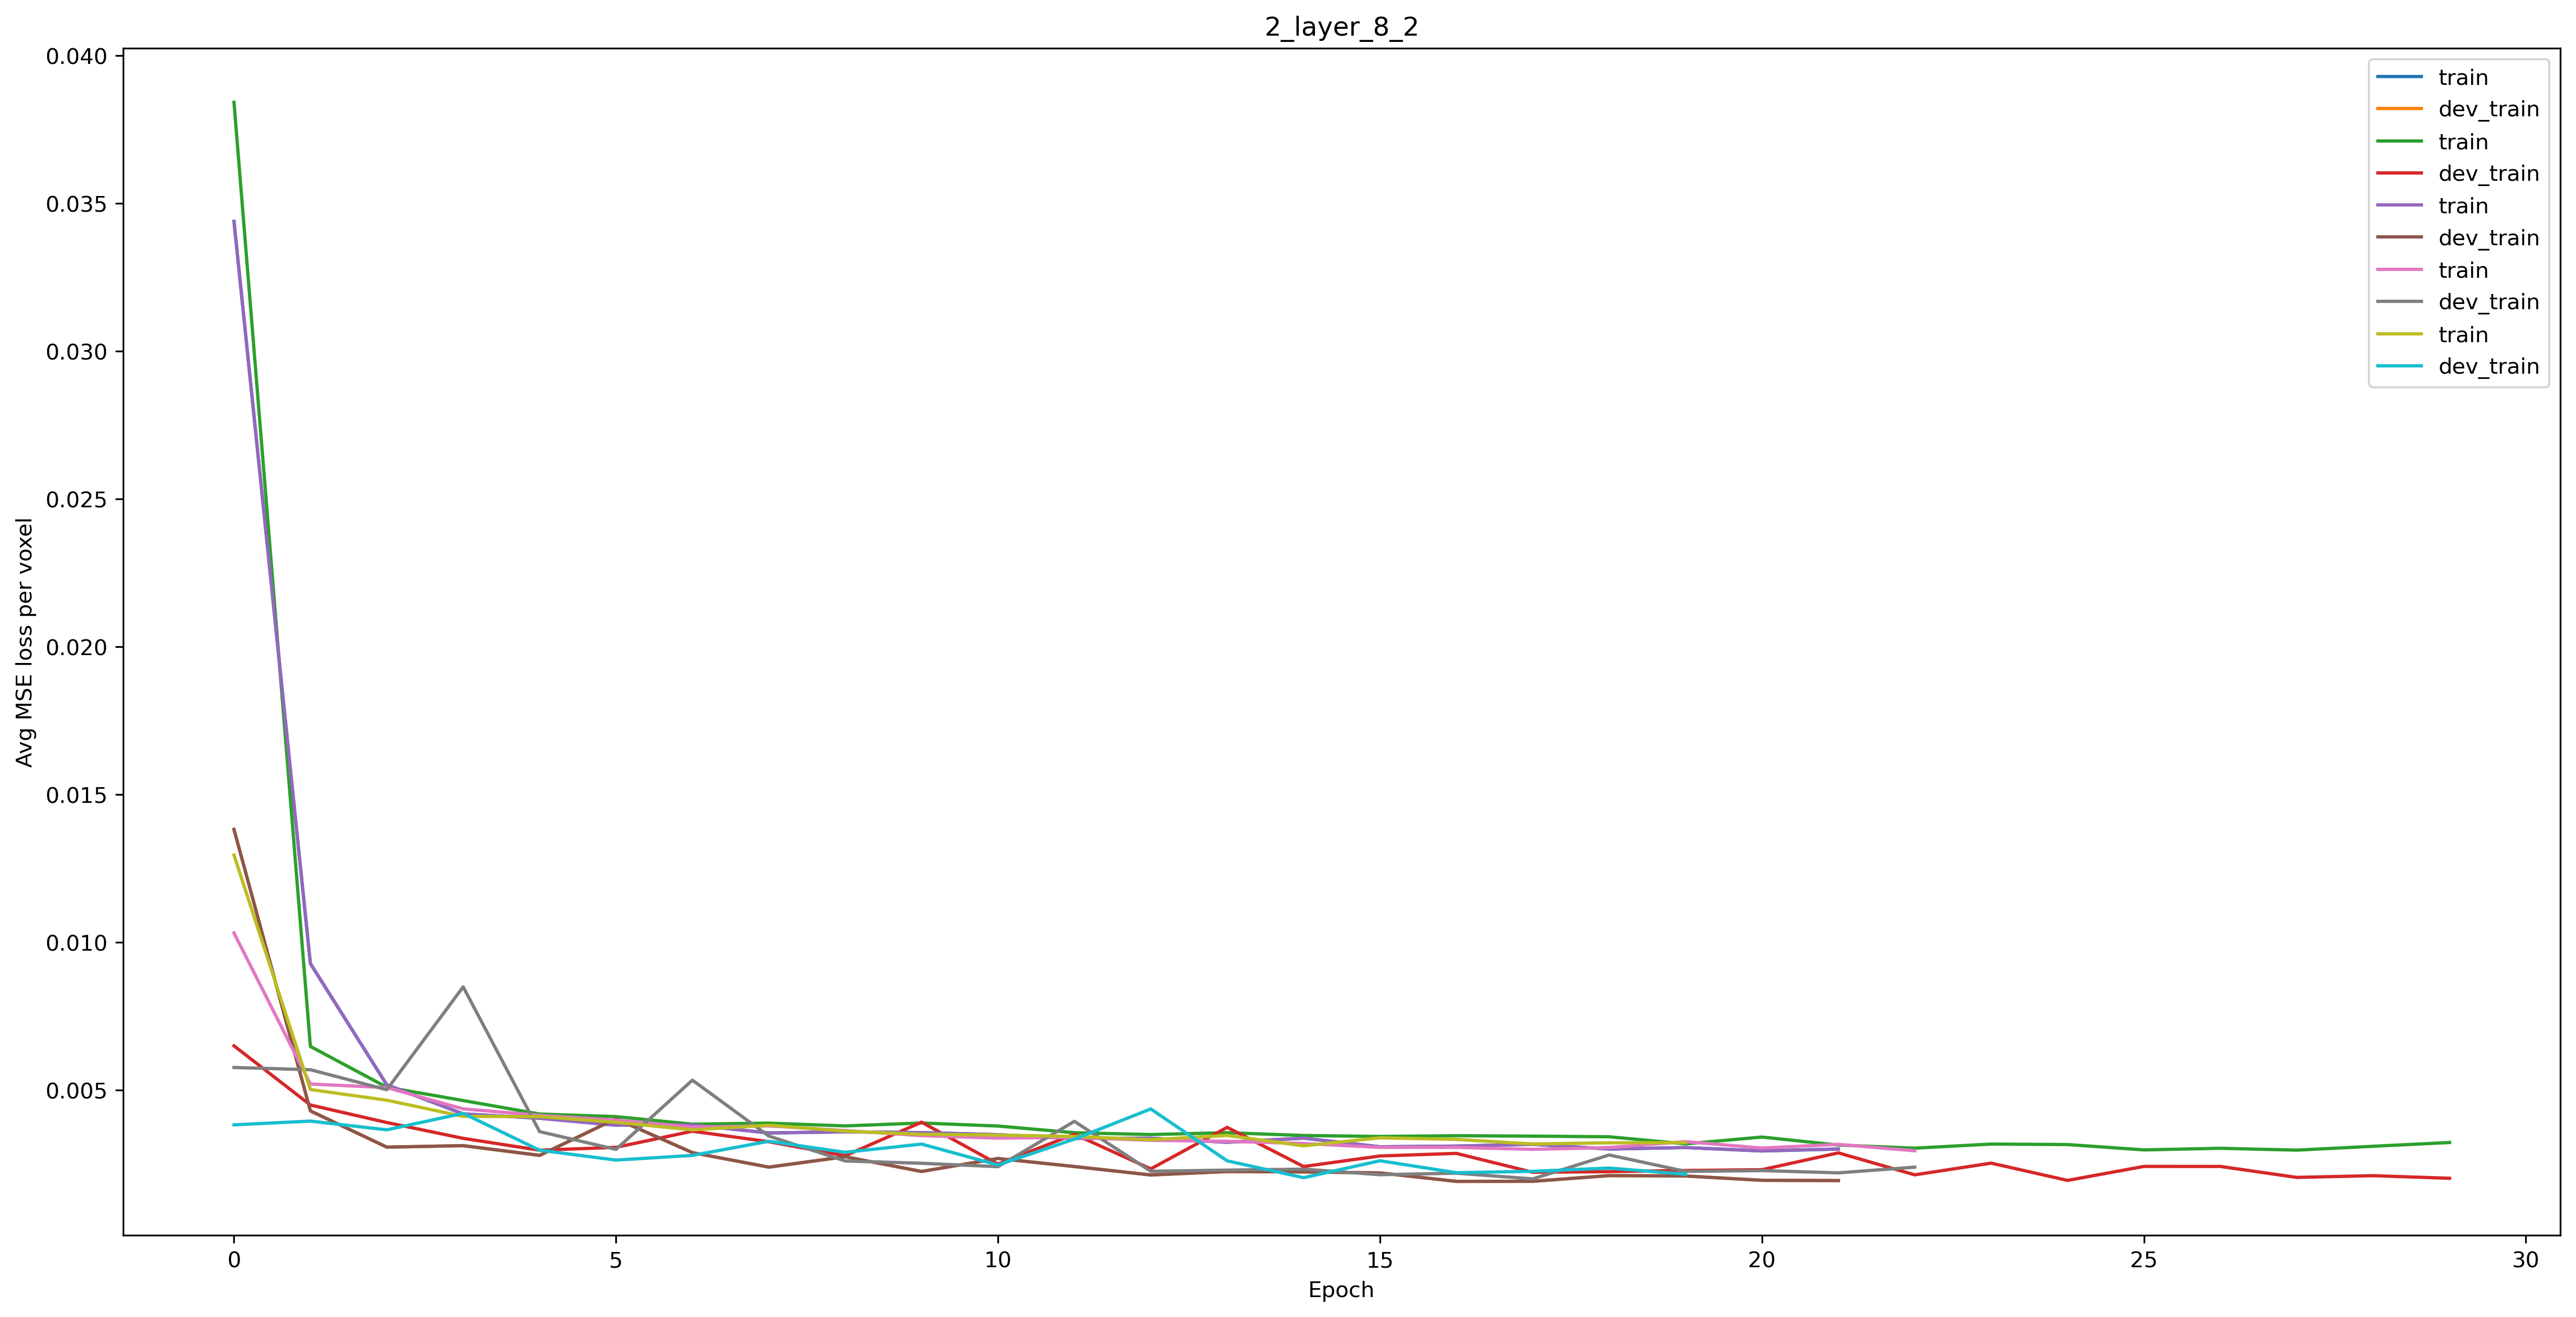

In [18]:
plt.figure(figsize=(20, 10), dpi=300)

plt.title('Training');

candidates=['1_layer_2_2','1_layer_4_1','1_layer_2_2','2_layer_32_1','2_layer_8_2']

for i in range(len(candidates)):
    plt.title(candidates[i])
    
    train_loss, dev_train_loss = load_training('../../1_Data/2_Trained_AE/'+candidates[i])
    
    plt.plot(train_loss, label='train')
    plt.plot(dev_train_loss, label='dev_train')
    
    #plt.ylim([0,0.008])
    
    plt.xlabel('Epoch')
    plt.ylabel('Avg MSE loss per voxel')
    
    plt.legend()

### Qualitative assessment of performance

test control CHIASM
(9, 4, 12, 12, 4)


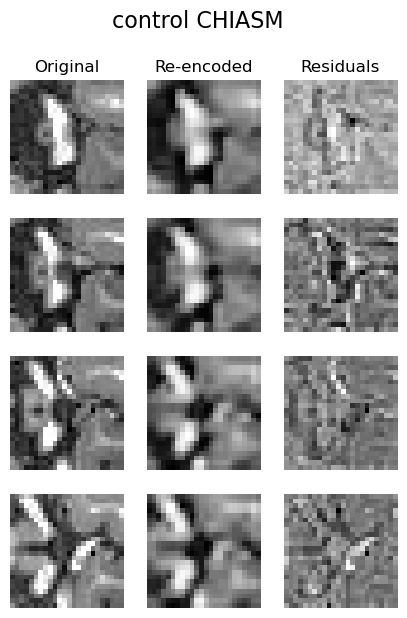

test control Ather et al.
(10, 4, 12, 12, 4)


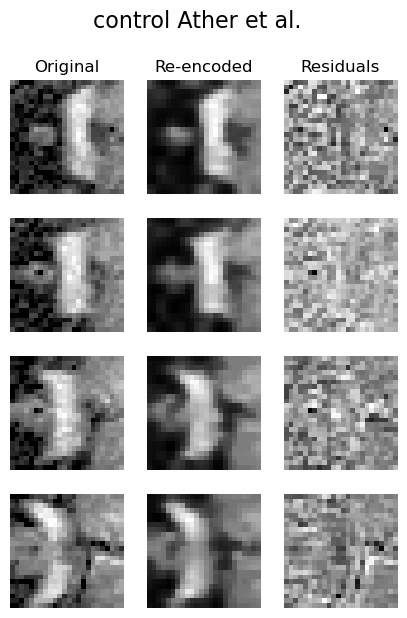

test albinism CHIASM
(8, 4, 12, 12, 4)


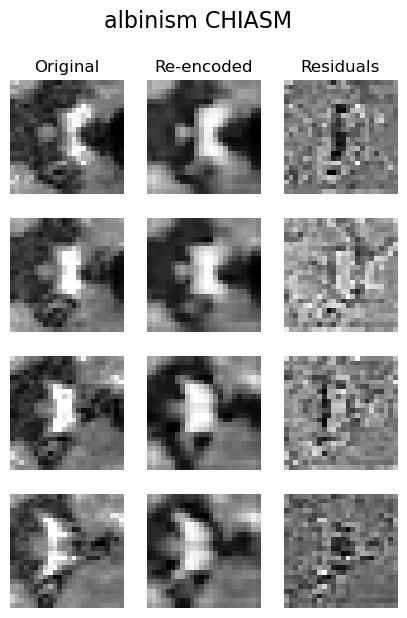

test albinism Ather et al.
(10, 4, 12, 12, 4)


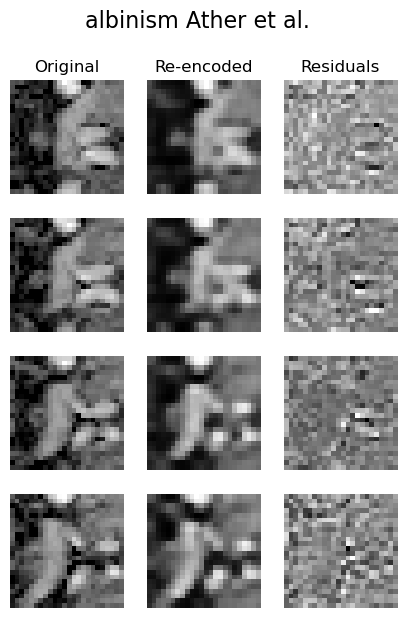

In [50]:
# Inspect input, latent representations and output for the best approach

for group in ['test']:
    for label in ['control','albinism']:
        for dataset in ['CHIASM','UoN']:
            
            if dataset == 'UoN':
                print(group, label, 'Ather et al.')
            else:
                print(group, label, dataset)
        
            input_sample = next(enumerate(dataloader_chiasm[group][dataset][label]))
            
            network = UNet_1_layer(1,1,2,2)
            network.load_state_dict(torch.load('../../1_Data/2_Trained_AE/1_layer_2_2/optimal_weights'))
            network.eval()
            
            output_sample = network(input_sample[1]['chiasm']['data'])
            
            latent_sample = network.output_latent_representations(input_sample[1]['chiasm']['data']);
            
            # Visualize sample
            input_data = input_sample[1]['chiasm']['data']
            latent_data = latent_sample.detach().numpy()
            output_data = output_sample.detach().numpy()
            
            #
            print(latent_data.shape)
            
            # Input
            fig = plt.figure(figsize=(5,7), dpi=100);
            if dataset == 'UoN':
                fig.suptitle(label+' Ather et al.', fontsize=16)
            else:
                fig.suptitle(label+' '+dataset, fontsize=16)

            for i in range(4):

                plt.subplot(4,3,i*3+1);
                plt.imshow(input_data[0,0,:,:,2+i],cmap='gray');
                plt.axis('off')
                if i==0:
                    plt.title('Original')
                
                plt.subplot(4,3,i*3+2);
                plt.imshow(output_data[0,0,:,:,2+i],cmap='gray');
                plt.axis('off')
                if i==0:
                    plt.title('Re-encoded')
                    
                plt.subplot(4,3,i*3+3);
                plt.imshow(input_data[0,0,:,:,2+i]-output_data[0,0,:,:,2+i],cmap='gray');
                plt.axis('off')
                if i==0:
                    plt.title('Residuals')
            
            plt.show()

test control CHIASM
(9, 4, 12, 12, 4)


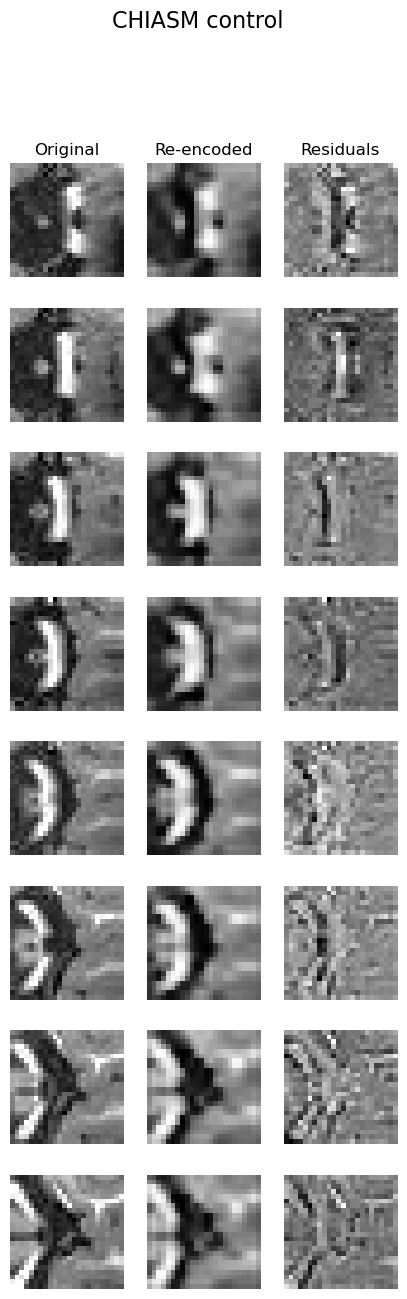

test control UoN
(10, 4, 12, 12, 4)


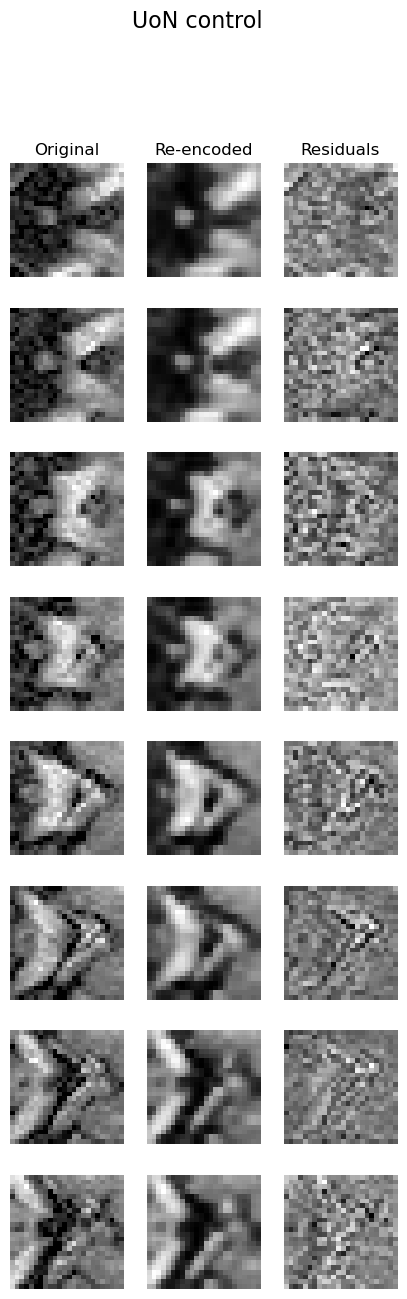

test albinism CHIASM
(8, 4, 12, 12, 4)


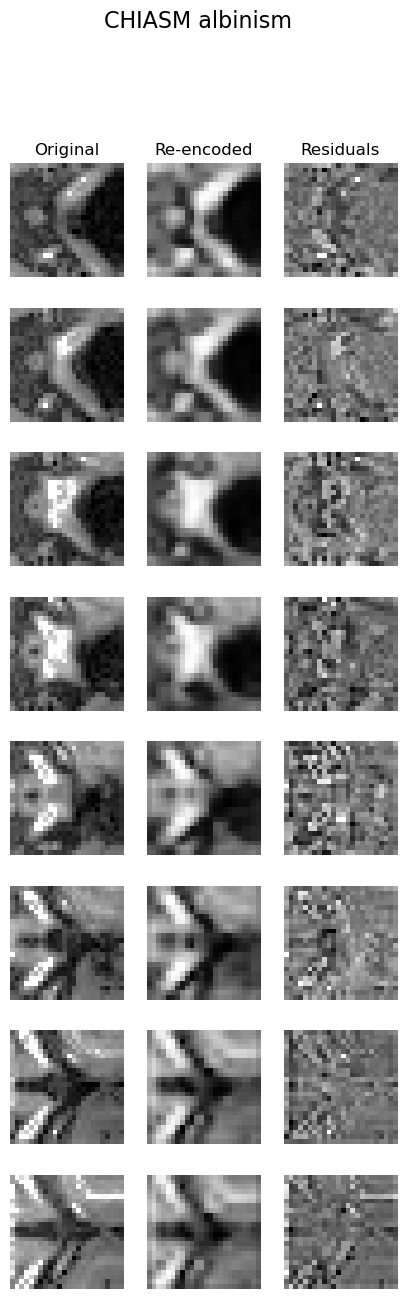

test albinism UoN
(10, 4, 12, 12, 4)


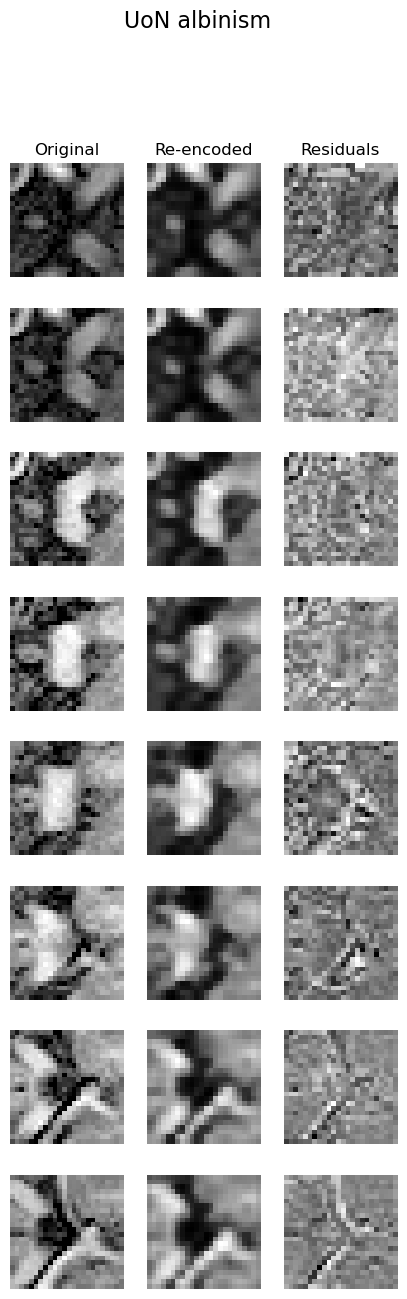

In [107]:
# Inspect input, latent representations and output for the best approach

for group in ['test']:
    for label in ['control','albinism']:
        for dataset in ['CHIASM','UoN']:
            
            print(group, label, dataset)
        
            input_sample = next(enumerate(dataloader_chiasm[group][dataset][label]))
            
            network = UNet_1_layer(1,1,2,2)
            network.load_state_dict(torch.load('../../1_Data/2_Trained_AE/1_layer_2_2/optimal_weights'))
            network.eval()
            
            output_sample = network(input_sample[1]['chiasm']['data'])
            
            latent_sample = network.output_latent_representations(input_sample[1]['chiasm']['data']);
            
            # Visualize sample
            input_data = input_sample[1]['chiasm']['data']
            latent_data = latent_sample.detach().numpy()
            output_data = output_sample.detach().numpy()
            
            #
            print(latent_data.shape)
            
            # Input
            fig = plt.figure(figsize=(5,15), dpi=100);
            fig.suptitle(dataset+' '+label, fontsize=16)

            for i in range(8):

                plt.subplot(8,3,i*3+1);
                plt.imshow(input_data[0,0,:,:,i],cmap='gray');
                plt.axis('off')
                if i==0:
                    plt.title('Original')
                
                plt.subplot(8,3,i*3+2);
                plt.imshow(output_data[0,0,:,:,i],cmap='gray');
                plt.axis('off')
                if i==0:
                    plt.title('Re-encoded')
                    
                plt.subplot(8,3,i*3+3);
                plt.imshow(input_data[0,0,:,:,i]-output_data[0,0,:,:,i],cmap='gray');
                plt.axis('off')
                if i==0:
                    plt.title('Residuals')
            
            plt.show()

dev_test control CHIASM
(1, 4, 12, 12, 4)


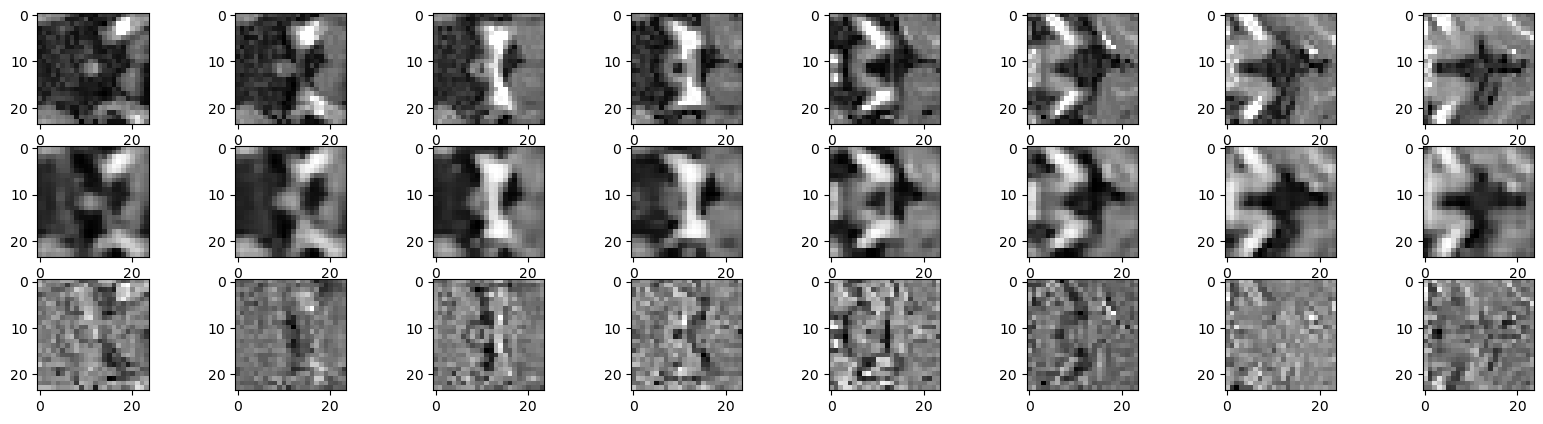

dev_test control UoN
(3, 4, 12, 12, 4)


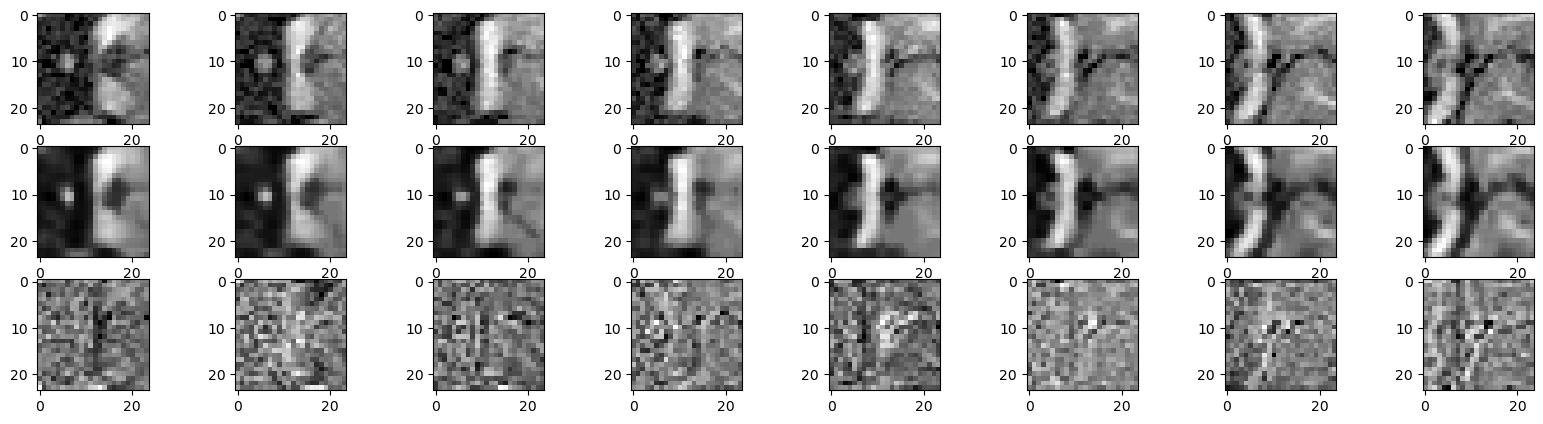

dev_test albinism CHIASM
(1, 4, 12, 12, 4)


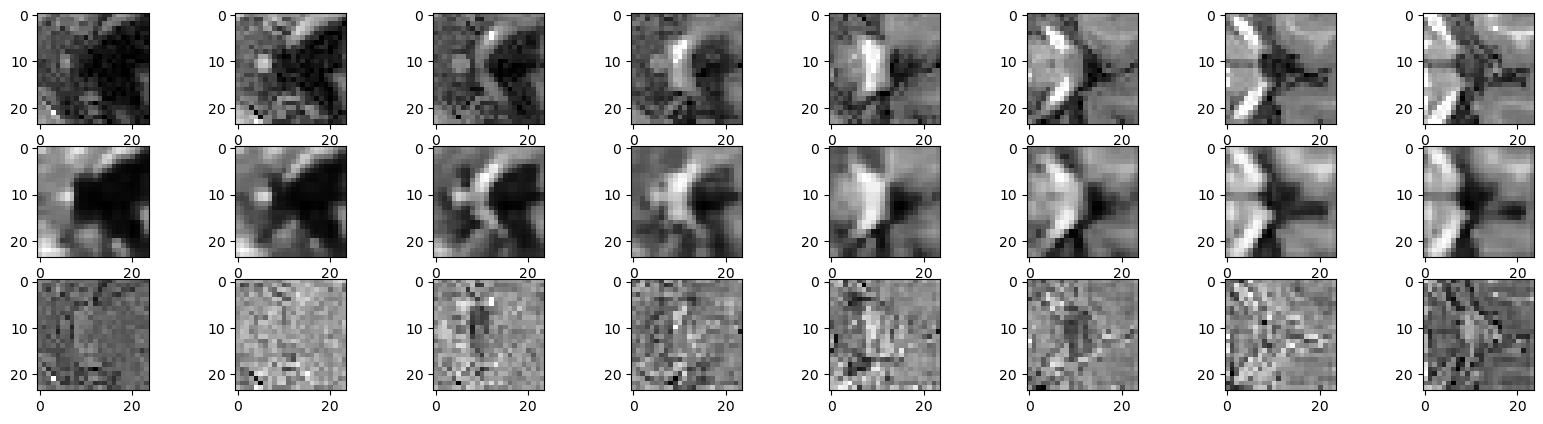

dev_test albinism UoN
(3, 4, 12, 12, 4)


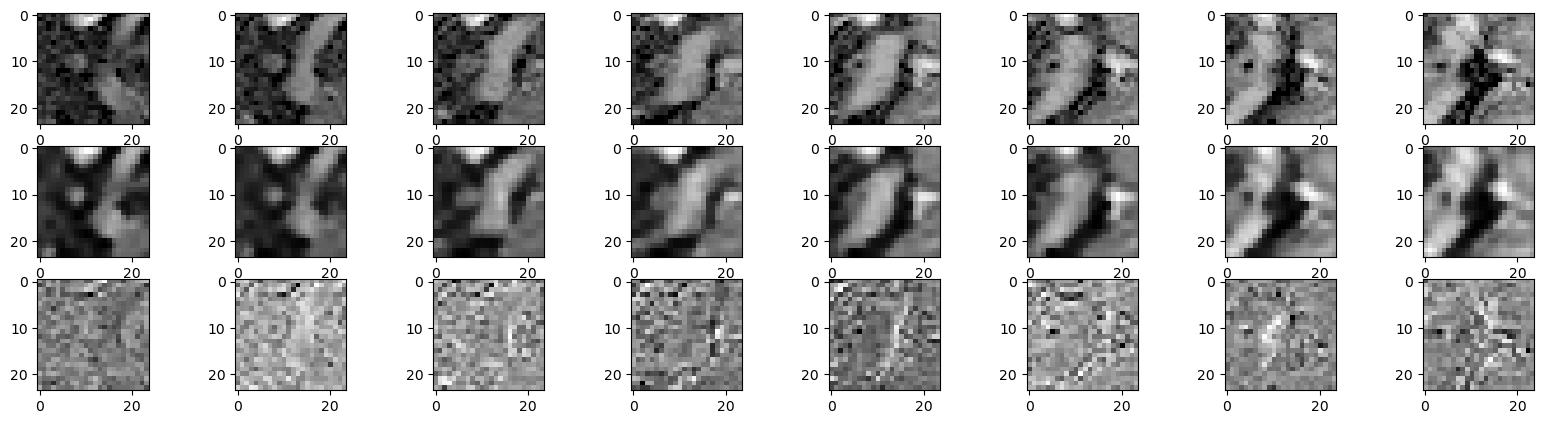

In [25]:
# Inspect input, latent representations and output for the best approach

for group in ['dev_test']:
    for label in ['control','albinism']:
        for dataset in ['CHIASM','UoN']:
            
            print(group, label, dataset)
        
            input_sample = next(enumerate(dataloader_chiasm[group][dataset][label]))
            
            network = UNet_1_layer(1,1,2,2)
            network.load_state_dict(torch.load('../../1_Data/2_Trained_AE/1_layer_2_2/optimal_weights'))
            network.eval()
            
            output_sample = network(input_sample[1]['chiasm']['data'])
            
            latent_sample = network.output_latent_representations(input_sample[1]['chiasm']['data']);
            
            # Visualize sample
            input_data = input_sample[1]['chiasm']['data']
            latent_data = latent_sample.detach().numpy()
            output_data = output_sample.detach().numpy()
            
            #
            print(latent_data.shape)
            
            # Input
            fig = plt.figure(figsize=(20,5), dpi=100);

            for i in range(8):

                plt.subplot(3,8,i+1);
                plt.imshow(input_data[0,0,:,:,i],cmap='gray');
                
                plt.subplot(3,8,i+9);
                plt.imshow(output_data[0,0,:,:,i],cmap='gray');
                
                plt.subplot(3,8,i+17);
                plt.imshow(input_data[0,0,:,:,i]-output_data[0,0,:,:,i],cmap='gray');
    
            plt.show()

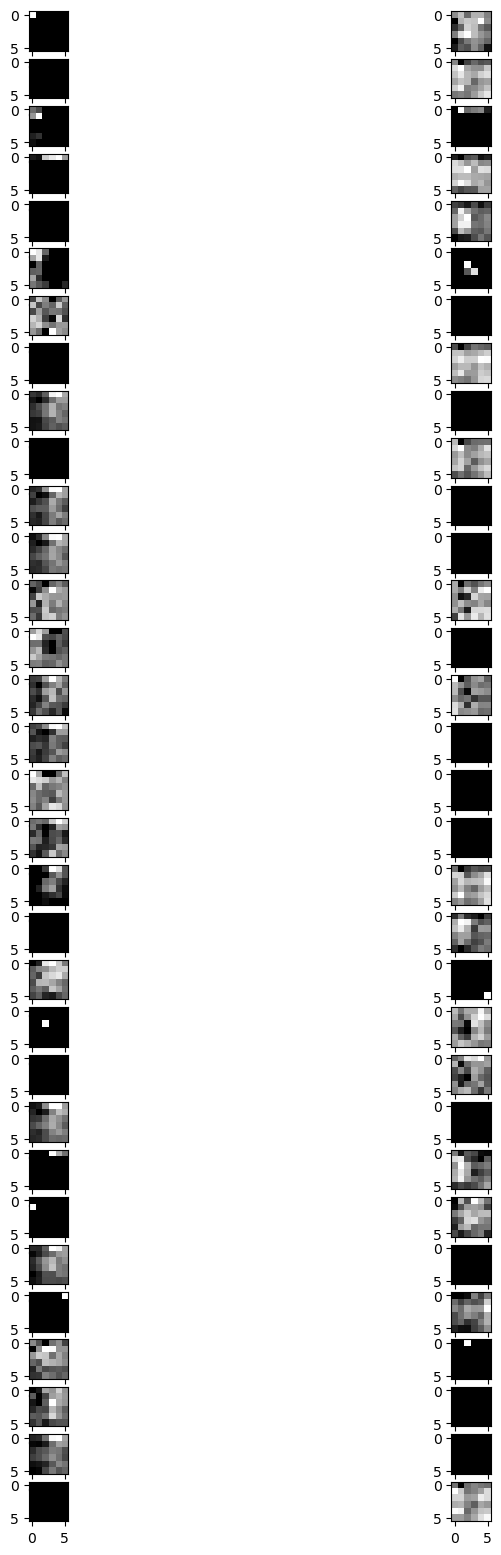

In [17]:
# Latent representations
fig = plt.figure(figsize=(10,20), dpi=100);

for i in range(latent_data.shape[1]):
    
    plt.subplot(latent_data.shape[1],2,i*2+1);
    plt.imshow(latent_data[1,i,:,:,0],cmap='gray');
    
    plt.subplot(latent_data.shape[1],2,i*2+2);
    plt.imshow(latent_data[1,i,:,:,1],cmap='gray');
    
    

In [18]:
# Chosen 1_layer_2_2 and 2_layer_32_1